# ongoing implementation of ExportXML importer (discoursegraphs branch: exportxml)

* initially, I was working on Tueba/D-Z 5.0, but now I have version 8.0 available
* the whole corpus is available as a single XML file, which would result in a graph  
  that is way to large for networkx (ca. 1.7 million edges)
  
## Tueba-D/Z 5.0

* I assumed that the corpus could not be split into documents and therefore wrote  
  a parser using igraph instead of networkx
* it turns out that each sentence has a ``origin`` attribute, e.g. ``T990507.2``,  
  which translates into (collection ID: T990507, document id: 2)
* all documents within a collection (NB: I will use those terms, Tueba doesn't)  
  have consequtively numbered token node IDs, i.e. if document 1 contains sentences  
  1 to 12, document 2 might contain sentences 13 to 43
  
## Tueba-D/Z 8.0

* ``tuebadz-8.0-mit-NE+Anaphern+Diskurs.exml.xml`` contains bad XML

```python
XMLSyntaxError: ID text_145 already defined, line 4663422, column 20
```

* two text IDs occur twice: ``text_3160`` and ``text_145``

In [1]:
import os
from collections import Counter
from operator import itemgetter
from lxml import etree, html
import igraph as ig

import discoursegraphs as dg

TUEBADZ5_FILE = os.path.expanduser(
    '~/corpora/tueba/tuebadz-5.0/data/XML/tuebadz-5.0.anaphora.export.xml')

TUEBADZ8_FILE = os.path.expanduser(
    '~/corpora/tueba/TuebaDZ8.0/tuebadz-8.0-mit-NE+Anaphern+Diskurs.exml.xml')

HTML_PARSER = html.HTMLParser()

In [2]:
def add_ns(key, ns='http://www.w3.org/XML/1998/namespace'):
    """
    adds a namespace prefix to a string, e.g. turns 'foo' into
    '{http://www.w3.org/XML/1998/namespace}foo'
    """
    return '{{{namespace}}}{key}'.format(namespace=ns, key=key)

# represent the whole corpus in an iterable (over documents)

In [3]:
from lxml import etree

class ExportXMLCorpus(object):
    def __init__(self, exportxml_file):
        self.__context = etree.iterparse(exportxml_file, events=('end',), tag='text', recover=True)

    def __iter__(self):
        return iter(self.text_iter(self.__context))

    def next(self):
        # to build an iterable, __iter__() would be sufficient,
        # but adding a next() method is quite common
        return self.__iter__().next()
        
    def text_iter(self, context):
        """
        iterates over all the elements in an iterparse context (here: <text> elements)
        and yields an ExportXMLDocumentGraph instance for each of them.
        afterwards, the elements are removed from the DOM / main memory.
        """
        for _event, elem in context:
            yield ExportXMLDocumentGraph(elem)
            # removes element (and references to it) from memory after processing it
            elem.clear()
            while elem.getprevious() is not None:
                del elem.getparent()[0]
        del context 

In [68]:
import discoursegraphs as dg
from discoursegraphs import DiscourseDocumentGraph


class ExportXMLDocumentGraph(DiscourseDocumentGraph):
    """
    represents an ExportXML document as a document graph.
    """
    def __init__(self, text_element, name=None, namespace='exportxml',
                 precedence=False):
        """
        creates a document graph from a <text> element from an ExportXML file.
        
        Parameters
        ----------
        text_element : lxml.etree._Element
            a <text> element from an ExportXML file parsed with lxml
        name : str or None
            the name or ID of the graph to be generated. If no name is
            given, the xml:id of the <text> element is used
        namespace : str
            the namespace of the document (default: exportxml)
        precedence : bool
            If True, add precedence relation edges
            (root precedes token1, which precedes token2 etc.)
        """
        # super calls __init__() of base class DiscourseDocumentGraph
        super(ExportXMLDocumentGraph, self).__init__()

        self.name = name if name else text_element.attrib[add_ns('id')]
        self.ns = namespace
        self.root = self.ns+':root_node'
        self.add_node(self.root, layers={self.ns}, label=self.ns+':root_node')

        self.sentences = []
        self.tokens = []
        
        self.parsers = {
            'connective': self.add_connective,
            'discRel': self.add_discrel,
            'edu': self.add_edu,
            'edu-range': self.add_edurange,
            'ne': self.add_ne,
            'node': self.add_node_element, # add_node() is already present in graph class
            'relation': self.add_relation,
            'secEdge': self.add_secedge,
            'sentence': self.add_sentence,
            'splitRelation': self.add_splitrelation,
            'topic': self.add_topic,
            'word': self.add_word
        }
        
        self.parse_child_elements(text_element)

    def parse_child_elements(self, element):
        '''parses all children of an etree element'''
        for child in element.iterchildren():
            self.parsers[child.tag](child)

    def parse_descedant_elements(self, element):
        '''parses all descendants of an etree element'''
        for descendant in element.iterdescendants():
            self.parsers[descendant.tag](descendant)
  
    def add_connective(self, connective):
        """
        Parameters
        ----------
        connective : etree.Element
            etree representation of a <connective> element
            (annotates connective tokens)
        """
        pass # raise NotImplementedError
            
    def add_discrel(self, discrel):
        """
        Parameters
        ----------
        add_discrel : etree.Element
            etree representation of a <discRel> element
            Describes the relation between two EDUs.
            The ID of the other EDU is given in the arg2 attribute.
            Note, that arg2 can either reference an EDU (e.g. edu_9_3_2
            or an EDU range, e.g. edus9_3_1-5_0).
        """
        pass # raise NotImplementedError

    def add_edu(self, edu):
        """
        Parameters
        ----------
        edu : etree.Element
            etree representation of a <edu> element
            (annotates an EDU)
            Note: the arg1 EDU has a discRel child, the arg2 doesn't
        """
        pass # raise NotImplementedError
    
    def add_edurange(self, edurange):
        """
        Parameters
        ----------
        edurange : etree.Element
            etree representation of a <edurange> element
            (annotation that groups a number of EDUs)
        """
        pass # raise NotImplementedError

    def add_ne(self, ne):
        """
        Parameters
        ----------
        ne : etree.Element
            etree representation of a <ne> element
            (marks a text span -- (one or more <node> or <word> elements) as a named entity)
        """
        pass # raise NotImplementedError

    def add_node_element(self, node):
        """
        Parameters
        ----------
        node : etree.Element
            etree representation of a <node> element
            A <node> describes an element of a syntax tree.
            The root <node> element does not have a parent attribute,
            while non-root nodes do
        
        Example
        -------
        <node xml:id="s1_505" cat="SIMPX" func="--">
            <node xml:id="s1_501" cat="LK" func="-" parent="s1_505">
            
            # this is the root of the syntax tree of the sentence, but
            # it is not the root node of the sentence, since there might
            # be nodes outside of the tree which are children of the
            # sentence root node (e.g. <word> elements representing a
            # quotation mark)

        """
        node_id = self.get_element_id(node)
        parent_id = self.get_parent_id(node)
        self.add_node(node_id, layers={self.ns, self.ns+':syntax'},
                      attr_dict=self.element_attribs_to_dict(node),
                      label=node.attrib['cat'])
        self.add_edge(parent_id, node_id, edge_type=dg.EdgeTypes.dominance_relation)

    def add_relation(self, relation):
        """
        Parameters
        ----------
        relation : etree.Element
            etree representation of a <relation> element
            A <relation> always has a type attribute and inherits
            its ID from its parent element. In the case of a non-expletive
            relation, it also has a target attribute.

        Example
        -------

          <node xml:id="s29_501" cat="NX" func="ON" parent="s29_523">
           <relation type="expletive"/>
           <word xml:id="s29_2" form="es" pos="PPER" morph="nsn3" lemma="es"
                 func="HD" parent="s29_501" dephead="s29_14" deprel="SUBJ"/>
          </node>

          ...

         <node xml:id="s4_507" cat="NX" func="ON" parent="s4_513">
          <relation type="coreferential" target="s1_502"/>
          <node xml:id="s4_505" cat="NX" func="HD" parent="s4_507">
          ...
          </node>
         </node>
        """
        parent_node_id = self.get_parent_id(relation)
        reltype = relation.attrib['type']
        # add relation type information to parent node
        self.node[parent_node_id].update({'relation': reltype})
        if 'target' in relation.attrib:
            self.add_edge(parent_node_id, relation.attrib['target'],
                          layers={self.ns, self.ns+':'+reltype,
                                  self.ns+':coreference'},
                          label=reltype,
                          edge_type=dg.EdgeTypes.pointing_relation)

    def add_secedge(self, secedge):
        """
        Parameters
        ----------
        secedge : etree.Element
            etree representation of a <secedge> element
        A <secEdge> element has a cat and a parent attribute,
        but inherits its ID from its parent element.
        It describes a secondary edge in a tree-like syntax representation.  
        """
        pass # raise NotImplementedError

    def add_sentence(self, sentence):
        """
        Parameters
        ----------
        sentence : etree.Element
            etree representation of a sentence
            (syntax tree with coreference annotation)
        """
        sent_root_id = sentence.attrib[add_ns('id')]
        # add edge from document root to sentence root
        self.add_edge(self.root, sent_root_id, edge_type=dg.EdgeTypes.spanning_relation)
        self.sentences.append(sent_root_id)

        self.parse_descedant_elements(sentence)
        pass # raise NotImplementedError

    def add_splitrelation(self, splitrelation):
        """
        Parameters
        ----------
        splitrelation : etree.Element
            etree representation of a <splitRelation> element
            A <splitRelation> annotates its parent element (e.g. as an anaphora).
            Its parent can be either a <word> or a <node>.
            A <splitRelation> has a target attribute, which describes
            the targets (plural! e.g. antecedents) of the relation.
        """
        pass # raise NotImplementedError    

    def add_topic(self, topic):
        """
        Parameters
        ----------
        topic : etree.Element
            etree representation of a <topic> element
            (topic annotation of a text span, e.g. a sentence)
        """
        pass # raise NotImplementedError

    def add_word(self, word):
        """
        Parameters
        ----------
        word : etree.Element
            etree representation of a <word> element
            (i.e. a token, which might contain child elements)
        """
        word_id = self.get_element_id(word)
        parent_id = self.get_parent_id(word)
        self.tokens.append(word_id)
        # use all attributes except for the ID
        word_attribs = self.element_attribs_to_dict(word)
        # add the token string under the key namespace:token
        token_str = word_attribs['form']
        word_attribs.update({self.ns+':token': token_str, 'label': token_str})
        self.add_node(word_id, layers={self.ns, self.ns+':token'}, attr_dict=word_attribs)
        self.add_edge(parent_id, word_id, edge_type=dg.EdgeTypes.dominance_relation)
        
        self.parse_child_elements(word)

    def element_attribs_to_dict(self, element):
        """
        converts the .attrib attributes of an etree element (from ``lxml.etree._Attrib``)
        into a dict, leaving out the xml:id attribute.
        """
        return {key: val for (key, val) in element.attrib.items()
                if key != add_ns('id')}
    
    def get_element_id(self, element):
        """
        Returns the ID of an element (or, if the element doesn't have one:
        the ID of its parent). Returns an error, if both elements have no ID.
        """
        id_attrib_key = add_ns('id')
        if id_attrib_key in element.attrib:
            return element.attrib[id_attrib_key]
        try:
            return element.getparent().attrib[id_attrib_key]
        except KeyError as e:
            raise KeyError(
                'Neither the element "{}" nor its parent "{}" '
                'have an ID'.format(element, element.getparent()))
    
    def get_parent_id(self, element):
        """returns the ID of the parent of the given element"""
        if 'parent' in element.attrib:
            return element.attrib['parent']
        else:
            return element.getparent().attrib[add_ns('id')]

In [69]:
exml_corpus = ExportXMLCorpus(TUEBADZ8_FILE)

text = exml_corpus.next()

In [70]:
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


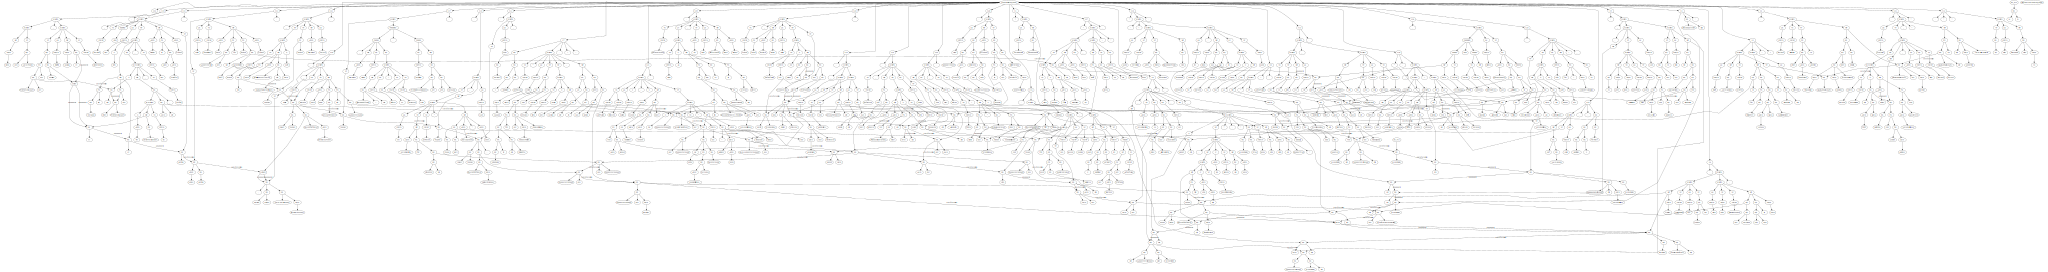

In [71]:
%dotstr dg.print_dot(text)

# What do those ExportXML elements represent?

```python
elements = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for descendant in text_elem.iterdescendants():
        elements[descendant.tag] += 1
```

```python
from operator import itemgetter
sorted(elements.items(), key=itemgetter(1), reverse=True)

[('node', 1611076),
 ('word', 1365642),
 ('relation', 109239),
 ('sentence', 75408),
 ('ne', 66564),
 ('secEdge', 5450),
 ('edu', 1612),
 ('connective', 1522),
 ('discRel', 1458),
 ('edu-range', 323),
 ('splitRelation', 297),
 ('topic', 141)]
```

## Do ``<text>`` elements only contain ``<sentence>`` as children? NO!

* ``<topic>`` can occur as a parent of ``<sentence>`` and describes them
* ``<topic>`` never occur elsewhere

```xml
...
   <word xml:id="s132_21" form="." pos="$." lemma="." func="--" deprel="ROOT"/>
   </edu>
  </sentence>
 </topic>
 <topic xml:id="topic_9_2" description="Probleme bei weiblichen Alkoholismus">
  <sentence xml:id="s133">
   <node xml:id="s133_530" cat="SIMPX" func="--">
    <edu xml:id="edu_9_8_0">
...
```

* ```<edu-range>``` seems to glue together a number of ```<edu>`` elements,  
  which may be scattered over a number of sentences
* ```<edu-range>``` may or may not contain a ``span`` attribute

```python
   <edu-range xml:id="edus9_3_1-5_0" span="s128_4..s130_7">
    <node xml:id="s128_525" cat="SIMPX" func="--">
     <edu xml:id="edu_9_3_1">
      <discRel relation="Continuation" marking="-" arg2="edu_9_3_2"/>
      <node xml:id="s128_506" cat="VF" func="-" parent="s128_525">
       <node xml:id="s128_505" cat="NX" func="ON" parent="s128_506">
        <relation type="expletive"/>
        <word xml:id="s128_4" form="Es" pos="PPER" morph="nsn3" lemma="es" func="HD" parent="s128_505" dephead="s128_5" deprel="SUBJ"/>
       </node>
      </node>
```



## Do ``<topic>`` elements describe one or potentially more sentences?

In [ ]:
elements = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for child in text_elem.iterchildren():
        elements[child.tag] += 1
        
sorted(elements.items(), key=itemgetter(1), reverse=True)

In [ ]:
# children of <topic>

elements = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for topic in text_elem.iterdescendants('topic'):
        for child in topic.iterchildren():
            elements[child.tag] += 1
        
sorted(elements.items(), key=itemgetter(1), reverse=True)

# Do ``<sentence>`` elements only contain ``<node>`` as children? NO!

* ``<word>, <ne>, <edu> and <edu-range>`` can be children of ``<sentence>`` as well!
* e.g. quotation marks ``<word>`` elements occur outside of a ``<node>``

```xml
 <sentence xml:id="s2196">
  <word xml:id="s2196_1" form='"' pos="$(" lemma='"' func="--" deprel="ROOT"/>
  <node xml:id="s2196_526" cat="SIMPX" func="--">
```

In [ ]:
# all types of children of <sentence>

sent_children = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for sentence in text_elem.iterdescendants('sentence'):
        for child in sentence.iterchildren():
            sent_children[child.tag] += 1
        
sorted(sent_children.items(), key=itemgetter(1), reverse=True)

In [ ]:
# all types of descendants of <sentence>

sent_children = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for sentence in text_elem.iterdescendants('sentence'):
        for child in sentence.iterdescendants():
            sent_children[child.tag] += 1
        
sorted(sent_children.items(), key=itemgetter(1), reverse=True)

# Do ``<word>`` elements have children? YES!

In [ ]:
word_children = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for word in text_elem.iterdescendants('word'):
        for child in word.iterdescendants():
            word_children[child.tag] += 1

sorted(word_children.items(), key=itemgetter(1), reverse=True)

* when parsing ``<word>`` as tokens for a sentence, keep an eye on ``<relation>, <connective> and <splitRelation>``
* ``<relation>`` can either occur as a daughter of ``<word>`` **OR** as a predecessor of ``<node>`` or ``<word>``
* a ``<relation>`` always gets its ID from its parent and contains its target as an attribute

```xml
      <node xml:id="s149_507" cat="NX" func="ON" parent="s149_509">
       <relation type="anaphoric" target="s149_501"/>
       <word xml:id="s149_8" form="sie" pos="PPER" morph="np*3" lemma="sie" func="HD" parent="s149_507" dephead="s149_10" deprel="SUBJ"/>
      </node>
```

```xml
     <node xml:id="s4_507" cat="NX" func="ON" parent="s4_513">
      <relation type="coreferential" target="s1_502"/>
      <node xml:id="s4_505" cat="NX" func="HD" parent="s4_507">
       <word xml:id="s4_4" form="die" pos="ART" morph="nsf" lemma="die" func="-" parent="s4_505" dephead="s4_5" deprel="DET"/>
       <ne xml:id="ne_32" type="ORG">
        <word xml:id="s4_5" form="Arbeiterwohlfahrt" pos="NN" morph="nsf" lemma="Arbeiterwohlfahrt" func="HD" parent="s4_505" dephead="s4_3" deprel="SUBJ"/>
       </ne>
      </node>
      <node xml:id="s4_506" cat="NX" func="-" parent="s4_507">
       <ne xml:id="ne_33" type="GPE">
        <word xml:id="s4_6" form="Bremen" pos="NE" morph="nsn" lemma="Bremen" func="HD" parent="s4_506" dephead="s4_5" deprel="APP"/>
       </ne>
      </node>
     </node>
```

```xml
       <word xml:id="s4_7" form="ihren" pos="PPOSAT" morph="asm" lemma="ihr" func="-" parent="s4_509" dephead="s4_9" deprel="DET">
        <relation type="anaphoric" target="s4_507"/>
       </word>
```

* ``<connective>`` is an annotation of a word

```xml
      <word xml:id="s29_1" form="Als" pos="KOUS" lemma="als" func="-" parent="s29_500" dephead="s29_14" deprel="KONJ">
       <connective konn="als" rel1="Temporal" rel2="enable"/>
      </word>
```

* ``<splitRelation>`` can occur as a predecessor of ``<word>`` (i.e. a child of ``<node>``)   **OR**  
  as a child of ``<word>``
  and describes which targets (plural!) its relation has

```xml
        <node xml:id="s2527_528" cat="NX" func="-" parent="s2527_529">
         <splitRelation type="split_antecedent" target="s2527_504 s2527_521"/>
         <word xml:id="s2527_32" form="beider" pos="PIDAT" morph="gpf" lemma="beide" func="-" parent="s2527_528" dephead="s2527_33" deprel="DET"/>
         <word xml:id="s2527_33" form="Firmen" pos="NN" morph="gpf" lemma="Firma" func="HD" parent="s2527_528" dephead="s2527_31" deprel="GMOD"/>
        </node>
```

```xml
        <word xml:id="s3456_12" form="ihr" pos="PPOSAT" morph="nsm" lemma="ihr" func="-" parent="s3456_507" dephead="s3456_14" deprel="DET">
         <splitRelation type="split_antecedent" target="s3456_505 s3456_9"/>
        </word>
```

# are ``<connective>`` elements always children of ``<word>``? YES!

In [ ]:
connective_parents = Counter()
for text_elem in ExportXMLCorpus(TUEBADZ8_FILE):
    for connective in text_elem.iterdescendants('connective'):
            connective_parents[connective.getparent().tag] += 1

sorted(connective_parents.items(), key=itemgetter(1), reverse=True)

In [ ]:
print text

In [ ]:
def get_text(text_element, result_list):
    text_str = 'ID: {}\nOrigin: {}\n\n'.format(text_element.attrib[add_ns('id')], text_element.attrib['origin'])
    for sentence in text_element.iterchildren('sentence'):
        sent_str = u'line: {}\n'.format(sentence.sourceline)
        sent_str += u' '.join(word.attrib['form'] for word in sentence.iterdescendants('word'))
        text_str += u'{}\n'.format(sent_str)
    result_list.append(text_str)

In [ ]:
results = []

context = etree.iterparse(TUEBADZ8_FILE, events=('end',), tag='text', recover=True)

In [ ]:
%load_ext memory_profiler

In [ ]:
# %memit fast_iter(context, get_text, results)
# peak memory: 330.86 MiB, increment: 249.31 MiB
# %time fast_iter(context, get_text, results)
# Wall time: 2min 13s

In [ ]:
%memit texts = list(fast_iter_yield(context, get_text, results))
# peak memory: 330.86 MiB, increment: 249.31 MiB
# %time fast_iter(context, get_text, results)
# Wall time: 2min 13s

## example sentences

In [ ]:
from collections import Counter

tree = etree.parse(TUEBADZ8_FILE)
sentence_origins = Counter()

sentences_iter = tree.iterfind('sentence')

In [ ]:
s0 = sentences_iter.next()

In [ ]:
print etree.tostring(s0)

## ExportXML ``<element>`` counts

### What about `<relation>` and `<anaphora>`?

In [ ]:
from collections import Counter, defaultdict

def count_element_positions(tree, element):
    element_positions = defaultdict(Counter)

    for elem_instance in tree.iter(element):
        element_positions['parent'][elem_instance.getparent().tag] += 1
        for child in elem_instance.getchildren():
            element_positions['children'][child.tag] += 1
    return element_positions

In [ ]:
count_element_positions(tree, 'relation')

In [ ]:
count_element_positions(tree, 'anaphora')

In [ ]:
anaphora_iter = tree.iter('anaphora')

for i in range(3):
    print etree.tostring(anaphora_iter.next())

In [ ]:
anaphora_iter = tree.iter('anaphora')
word_anaphora = [a for a in anaphora_iter if a.getparent().tag == 'word']
for word_ana in word_anaphora[:3]:
    print etree.tostring(word_ana)
        

## unusual examples

### expletive

```
~/corpora/tueba/tuebadz-5.0/data/XML $ ack-grep -A 5 s_11429_n_506 tuebadz-5.0.anaphora.export.xml
        <node cat="NX" comment="" func="ON" id="s_11429_n_506">
          <anaphora>
            <relation type="expletive" antecedent=""/>
          </anaphora>
          <word comment="" form="Es" func="HD" pos="PPER" morph="nsn3" id="s_11429_n_10"/>
        </node>
```

### split antecedent

```
27434-          <node cat="MF" comment="" func="-" id="s_382_n_511">
27435-            <node cat="NX" comment="" func="ON" id="s_382_n_501">
27436-              <anaphora>
27437:                <relation type="split_antecedent" antecedent="s_381_n_9,s_378_n_510"/>
27438-              </anaphora>
27439-              <word comment="" form="die" func="-" pos="ART" morph="npm" id="s_382_n_1"/>
27440-              <word comment="" form="Partner" func="HD" pos="NN" morph="npm" id="s_382_n_2"/>
27441-            </node>
27442-            <node cat="ADVX" comment="" func="OADVP" id="s_382_n_502">
27443-              <word comment="" form="miteinander" func="HD" pos="ADV" morph="--" id="s_382_n_3"/>
27444-            </node>
27445-          </node>
```

In [ ]:
anaphora_iter = tree.iter('anaphora')
for anaphora in anaphora_iter:
    # there's only one <relation> child element
    antecedent = anaphora.getchildren()[0].attrib['antecedent']

## ExportXML <element> meanings

* `<node>`: a node in a syntax tree
* `<word>`: a token in a sentence / syntax tree
* `<relation>`: a child of an `<anaphora>` element; it's always a leaf node  
   it has a `type` attrib (relation type) and an `antecedent` attrib (antecedent's node ID)  
   NB: if an anaphora has no antecedent, (e.g. if it's an `expletive` relation) the `antecedent` attrib  
   is an empty string!
* `<anaphora>`: a child of a `<node>` or `<word>` element; always has one `<relation>` child;  
  the element itself contains no information
* `<sentence>`: a sentence / syntax tree

```
 ('secedge', 4647),
 ('originDef', 2213),
 ('morphDef', 437),
 ('posDef', 56),
 ('edgeDef', 50),
 ('nodeDef', 29),
 ('editorDef', 26),
 ('secedgeDef', 7),
 ('comment', 6),


 ('posList', 1),
 ('secedgeList', 1),
 ('editorList', 1),
 ('edgeList', 1),
 ('originList', 1),
 ('format', 1),
 ('morphList', 1),
 ('nodeList', 1),
 ('export', 1)]
```

In [ ]:
def parse_anaphora(anaphora, source_id):
    """
    Parameters
    ----------
    anaphora : etree.Element
        an <anaphora> element
    source_id : str
        the node ID of the anaphora (points either to a <node> or a <word>)
    
    Returns
    -------
    antecedent : str
        node ID of the antecedent, e.g. ``s_4_n_527``
    relation_type : str
        anaphoric relation type, e.g. ``anaphoric`` or ``coreferential``
    """
    # there's only one <relation> child element
    relation = anaphora.getchildren()[0]
    return relation.attrib['antecedent'], relation.attrib['type']
    

def exportxml2igraph(exportxml_file):
    """
    TODO: add <node> and <word> attributes
    """
    # in igraph, adding a single edge is prohibitively slow,
    # as the whole index of the graph has to be rebuild!
    # http://stackoverflow.com/questions/13974279/igraph-why-is-add-edge-function-so-slow-ompared-to-add-edges
    # to speed this up, store the edges in a list & call add_edges() once!
    edges = []
    relations = {}
    idocgraph = ig.Graph(directed=True)
    
    treeiter = etree.iterparse(TUEBADZ_FILE, tag='sentence')
    for _action, sentence in treeiter:
        sent_root_id = sentence.attrib['origin']
        idocgraph.add_vertex(sent_root_id, label=sent_root_id)
        
        for element in sentence.iter('node', 'word', 'anaphora'):
            parent_element = element.getparent()
            # some <anaphora> are children of <word> elements
            if parent_element.tag in ('node', 'word'):
                parent_id = parent_element.attrib['id']
            elif parent_element.tag == 'sentence':
                parent_id = parent_element.attrib['origin']
            else:
                sys.stderr.write("Unexpected parent '{}' of element '{}'\n".format(parent_element, element))
            element_id = element.attrib.get('id') # <anaphora> doesn't have an ID

            if element.tag == 'node':
                idocgraph.add_vertex(element_id, label=element.attrib['cat'])
                edges.append((parent_id, element_id))
            elif element.tag == 'word':
                idocgraph.add_vertex(element_id, label=element.attrib['form'])
                edges.append((parent_id, element_id))

            else: # element.tag == 'anaphora'
                # <anaphora> doesn't have an ID, but it's tied to its parent element
                antecedent_str, relation_type = parse_anaphora(element, parent_id)
                if antecedent_str:
                    # there might be more than one antecedent
                    for antecedent_id in antecedent_str.split(','):
                        edge = (parent_id, antecedent_id)
                        edges.append(edge)
                        relations[edge] = relation_type
                else:
                    # there's no antecedent in case of an expletive anaphoric relation
                    relations[(parent_id, None)] = relation_type
      
    idocgraph.add_edges(edges)

    # igraph doesn't store nodes/edge names in a dict, so a lookup would be O(n)
    node_name2id = {node['name']: node.index for node in idocgraph.vs}
    edge_endpoints2id = {(edge.source, edge.target): edge.index
                         for edge in idocgraph.es}

    for (source, target) in relations:
        relation_type = relations[(source, target)]
        if target:
            edge_endpoints = (node_name2id[source], node_name2id[target])
            idocgraph.es[edge_endpoints2id[edge_endpoints]]['exportxml:relation_type'] = relation_type
#             idocgraph.es[idocgraph.get_eid(source, target)]['exportxml:relation_type'] = relation_type

        else:
            # there's no antecedent in case of an expletive anaphoric relation
            
            idocgraph.vs[node_name2id[source]]['exportxml:anaphora_type'] = relation_type
#             idocgraph.vs.select(name=source)['exportxml:anaphora_type'] = relation_type
    return idocgraph

            

In [ ]:
%%time
tuebagraph = exportxml2igraph(TUEBADZ_FILE)

In [ ]:
tuebagraph.ecount()

In [ ]:
tuebagraph.vcount()

In [ ]:
import igraph as ig

foo = ig.Graph(directed=True)
foo.add_vertices(['1','2','3','4'])
foo.add_edges([('1', '1'), ('1', '2'), ('3', '4')])

In [ ]:
# for e in foo.es:
#     print e, e.index, e.source, e.target
foo.es[0]

In [ ]:
for v in foo.vs:
    print v, v.index, v['name']

In [ ]:
foo.vs.select(name='2')

In [ ]:
foo.vs[0]

In [ ]:
list(foo.es.select(_source='3', _target='4'))

In [ ]:
from collections import defaultdict

def exportxml2dict(exportxml_file):
    nodes = []
    edges = []
    
    itree = etree.iterparse(TUEBADZ_FILE, tag='sentence')
    for _action, sentence in itree:
        sent_root_id = sentence.attrib['origin']
        nodes.append( (sent_root_id, sent_root_id) )
        
        for element in sentence.iter('node', 'word'):
            parent_element = element.getparent()
            if parent_element.tag == 'node':
                parent_id = parent_element.attrib['id']
            elif parent_element.tag == 'sentence':
                parent_id = parent_element.attrib['origin']
            else:
                sys.stderr.write("Unexpected parent '{}' of element '{}'\n".format(parent_element, element))
            element_id = element.attrib.get('id') # <anaphora> doesn't have an ID

            if element.tag == 'node':
                element_label = element.attrib['cat']
            elif element.tag == 'word':
                element_label = element.attrib['form']
            else:
                continue # for now, ignore other elements (e.g. <anaphora>)

            nodes.append( (element_id, element_label) )
            edges.append( (parent_id, element_id) )
    return nodes, edges

# Speed comparison

In [ ]:
%%time
nodes, edges = exportxml2dict(TUEBADZ_FILE) # 6.63s

## igraph: preprocessed node/edge lists, edges batch insert (total: 12.81 s)

- create node/edge lists
- add nodes one by one
- add edges in one go

```
%%time

idocgraph = ig.Graph()
for node_id, node_label in nodes:
    idocgraph.add_vertex(node_id, label=node_label)
idocgraph.add_edges(edges)
```

CPU times: user 6.06 s, sys: 112 ms, total: 6.18 s
Wall time: 6.18 s


## igraph: preprocessed node/edge lists, nodes & edges batch insert (total: 7.85 s)

- create node/edge lists
- add nodes in one go (without labels)
- add edges in one go

```python
%%time

idocgraph = ig.Graph()
node_ids = (node_id for (node_id, node_label) in nodes)
idocgraph.add_vertices(node_ids)
idocgraph.add_edges(edges)
```

CPU times: user 1.16 s, sys: 60 ms, total: 1.22 s
Wall time: 1.22 s

In [6]:
def exportxml2docgraph(exportxml_file):
    edges = []
    docgraph = dg.DiscourseDocumentGraph()
    edge_attribs = {'layers': {docgraph.ns}} # default edge attributes
    
    treeiter = etree.iterparse(TUEBADZ_FILE, tag='sentence')
    for _action, sentence in treeiter:
        sent_root_id = sentence.attrib['origin']
        docgraph.add_node(sent_root_id, label=sent_root_id)
        
        for element in sentence.iter('node', 'word'):
            parent_element = element.getparent()
            if parent_element.tag == 'node':
                parent_id = parent_element.attrib['id']
            elif parent_element.tag == 'sentence':
                parent_id = parent_element.attrib['origin']
            else:
                sys.stderr.write("Unexpected parent '{}' of element '{}'\n".format(parent_element, element))
            element_id = element.attrib.get('id') # <anaphora> doesn't have an ID

            if element.tag == 'node':
                element_label = element.attrib['cat']
            elif element.tag == 'word':
                element_label = element.attrib['form']
            else:
                continue # for now, ignore other elements (e.g. <anaphora>)

            docgraph.add_node(element_id, label=element_label)
            edges.append((parent_id, element_id, edge_attribs))
    docgraph.add_edges_from(edges)
    return docgraph